# Indonesia non-gas/oil commodity export/import analysis

## Background
Indonesia is one of the world's largest exporter of raw and agricultural products. It is the world's largest supplier of cloves (74%), as well as a major supplier of crude palm oil/coconut products (34%), coffee (26%), rubber (19%). https://www.fao.org/3/y4632e/y4632e0l.htm#:~:text=Indonesia's%20major%20agricultural%20exports%20consist,and%20spices%20(25.9%20percent).

### Cointegration
Policies tend to create convergence between imports and exports. This has been tested for 50 countries, where over the quarterly period of 1973 to 1998, where all 50 countries (except for Mexico) show strong signs of cointegration between imports and exports (https://www.sciencedirect.com/science/article/abs/pii/S1059056001001010). 

However, 1998 is the end of the New Order Era in Indonesia. Post 1998, the Indonesian government placed many new trade policies that might changed the long-run relationships between import and export. I would like to check on whether cointegration between import and export is maintained about a decade after the end of the New Order Era.

## Goals

1) Create a model to forecast the Indonesian import/export monthly time series 


2) Perform cointegration analysis on the import and export time series

Data source: 
https://www.bps.go.id/subject/8/ekspor-impor.html#subjekViewTab3

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import pmdarima as pm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from pmdarima.arima import ndiffs
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import coint
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
sns.set_style("darkgrid")
sns.set(font_scale=2)

# Loading the data

In [3]:
df = pd.read_csv('data_ex.csv', header=0)

In [4]:
df.head()

,No.,Bulan,Nilai Ekspor (US $),Berat Ekspor (KG),Nilai Impor (US $),Berat Impor (KG)
0,1,Januari,"19 173 699 043,36","27 176 531 455,73","18 211 103 488,00","12 525 388 397,00"
1,2,Februari,"20 472 894 279,18","44 630 366 469,31","16 638 511 813,00","13 643 754 535,00"
2,3,Maret,"26 497 477 726,13","61 009 058 930,60","21 962 417 654,00","17 890 856 389,00"
3,4,April,"27 322 284 675,60","55 744 554 534,32","19 757 449 353,00","15 311 997 567,00"
4,5,Mei,"21 509 825 822,05","51 078 811 698,32","18 609 287 096,00","13 695 896 141,00"


First, let us rename the columns with more convenient names:

In [5]:
df = df.rename(columns={'No.':'month','Nilai Ekspor (US $)': 'exp_dol', 'Berat Ekspor (KG)': 'exp_weight', 'Nilai Impor (US $)': 'imp_dol', 'Berat Impor (KG)':'imp_weight'})

In [6]:
col_list = ['exp_dol', 'exp_weight', 'imp_dol', 'imp_weight']

Next, note that the columns are stored as strings! We will convert them into billions of US$ and billions of kg.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   month       108 non-null    int64 
 1   Bulan       108 non-null    object
 2   exp_dol     108 non-null    object
 3   exp_weight  108 non-null    object
 4   imp_dol     108 non-null    object
 5   imp_weight  108 non-null    object
dtypes: int64(1), object(5)
memory usage: 5.2+ KB


In [8]:
# Change units to billions US$ and billions kg
billion=10**9
df['exp_dol'] = (df['exp_dol'].str.replace(u'\xa0', u'')).str.replace(',','.').astype(float)/billion
df['exp_weight'] = (df['exp_weight'].str.replace(u'\xa0', u'')).str.replace(',','.').astype(float)/billion
df['imp_dol'] = (df['imp_dol'].str.replace(u'\xa0', u'')).str.replace(',','.').astype(float)/billion
df['imp_weight'] = (df['imp_weight'].str.replace(u'\xa0', u'')).str.replace(',','.').astype(float)/billion
df

,month,Bulan,exp_dol,exp_weight,imp_dol,imp_weight
0,1,Januari,19.173699,27.176531,18.211103,12.525388
1,2,Februari,20.472894,44.630366,16.638512,13.643755
2,3,Maret,26.497478,61.009059,21.962418,17.890856
3,4,April,27.322285,55.744555,19.757449,15.311998
4,5,Mei,21.509826,51.078812,18.609287,13.695896
...,...,...,...,...,...,...
103,8,Agustus,14.481642,43.484947,14.793237,11.676186
104,9,September,15.275846,46.043271,15.546096,13.158825
105,10,Oktober,15.292759,43.705130,15.327995,13.184342
106,11,November,13.544729,46.182204,14.041608,12.258277


# Data exploration

Let us look at the time series:

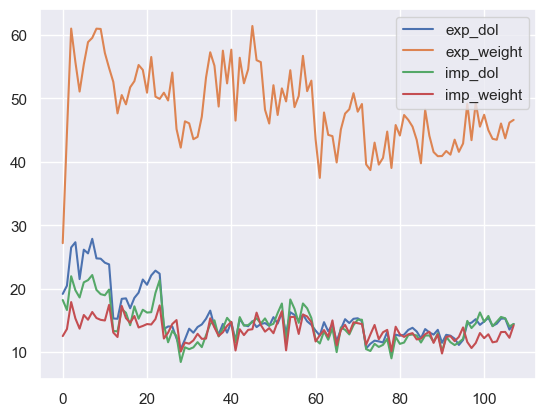

In [9]:
sns.set(font_scale=1)
fig = df.plot(y=col_list)

In [10]:
df.describe()

,month,exp_dol,exp_weight,imp_dol,imp_weight
count,108.000000,108.000000,108.000000,108.000000,108.000000
mean,6.500000,15.507748,48.442721,14.339862,13.470605
std,3.468146,3.996754,6.126358,2.968249,1.694506
min,1.000000,9.649504,27.176531,8.438627,9.777959
25%,3.750000,13.095465,44.020549,12.051415,12.388010
50%,6.500000,14.432579,47.841435,14.210155,13.194848
75%,9.250000,15.599244,52.624079,15.813879,14.639514
max,12.000000,27.862094,61.412978,22.150550,17.890856


The best way to explore this dataset for its lagged correlations are through the ACF and PACF plots:

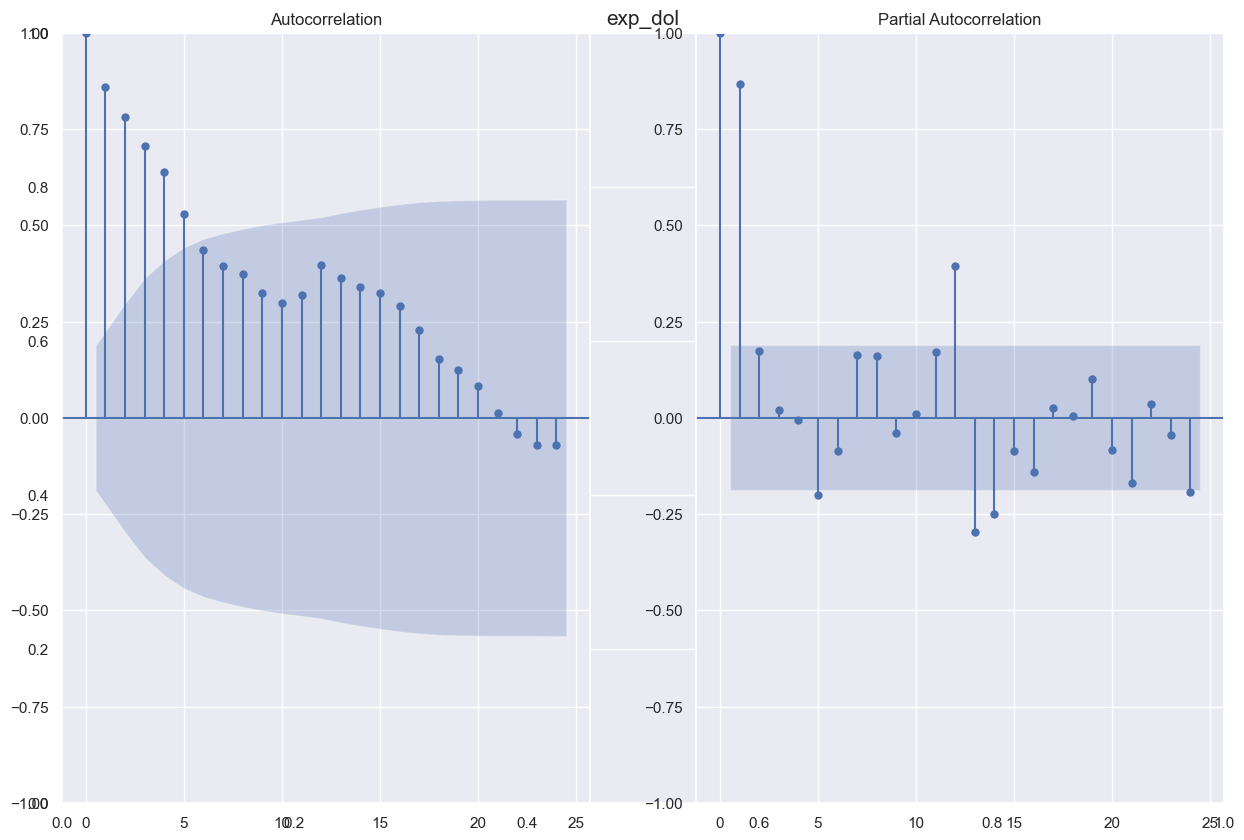

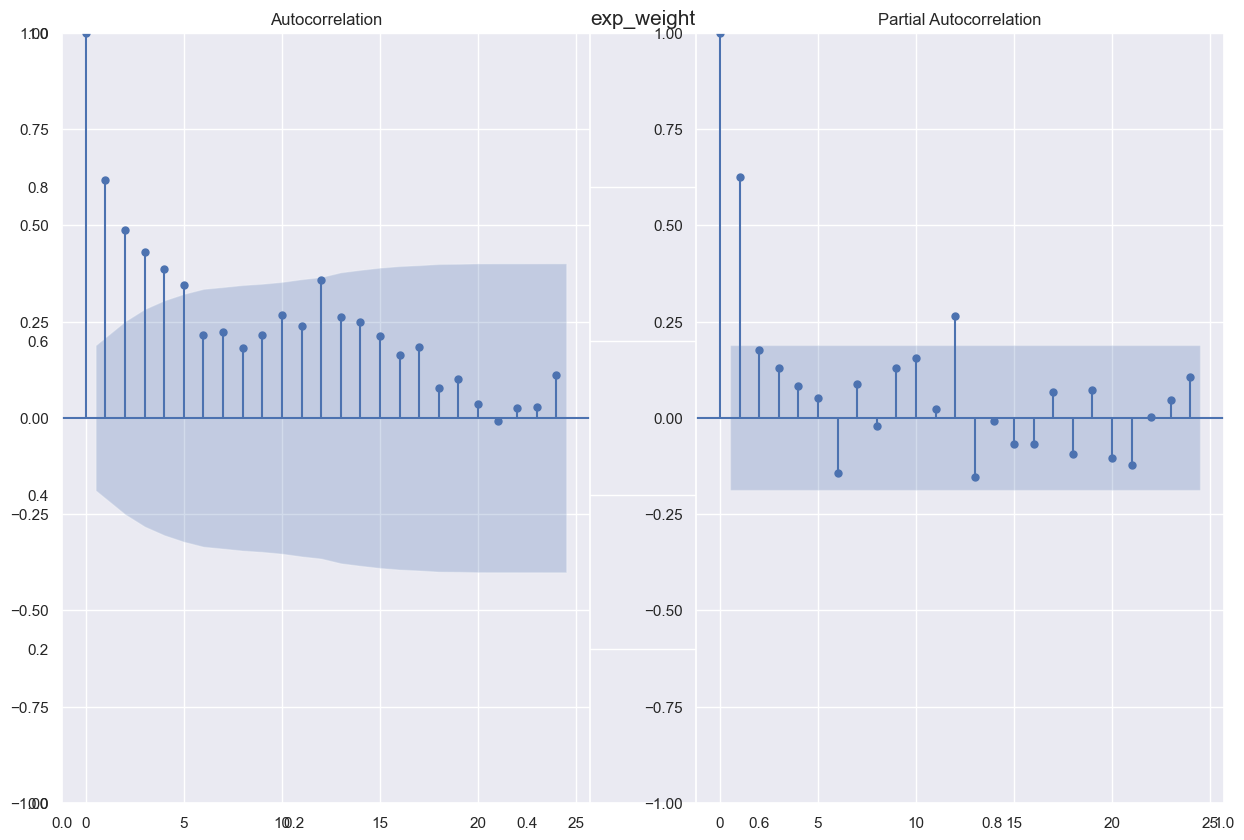

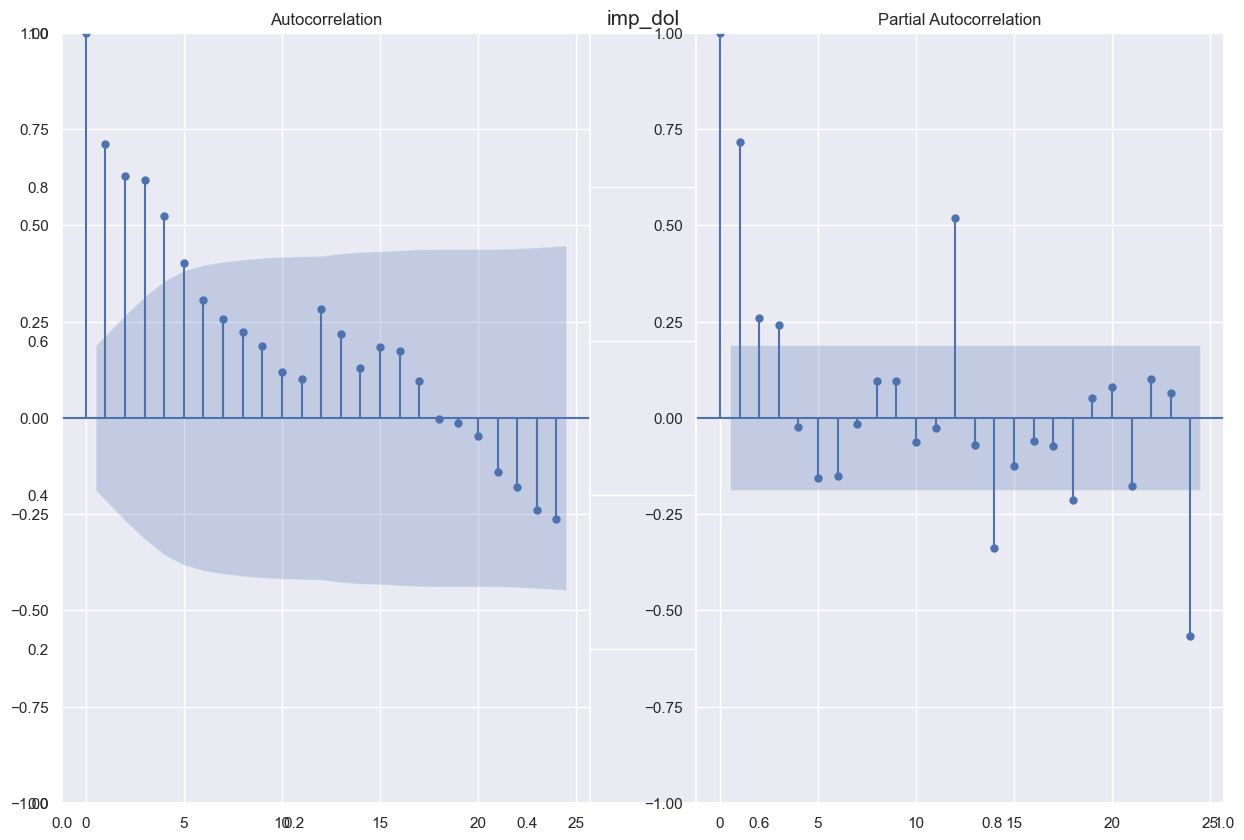

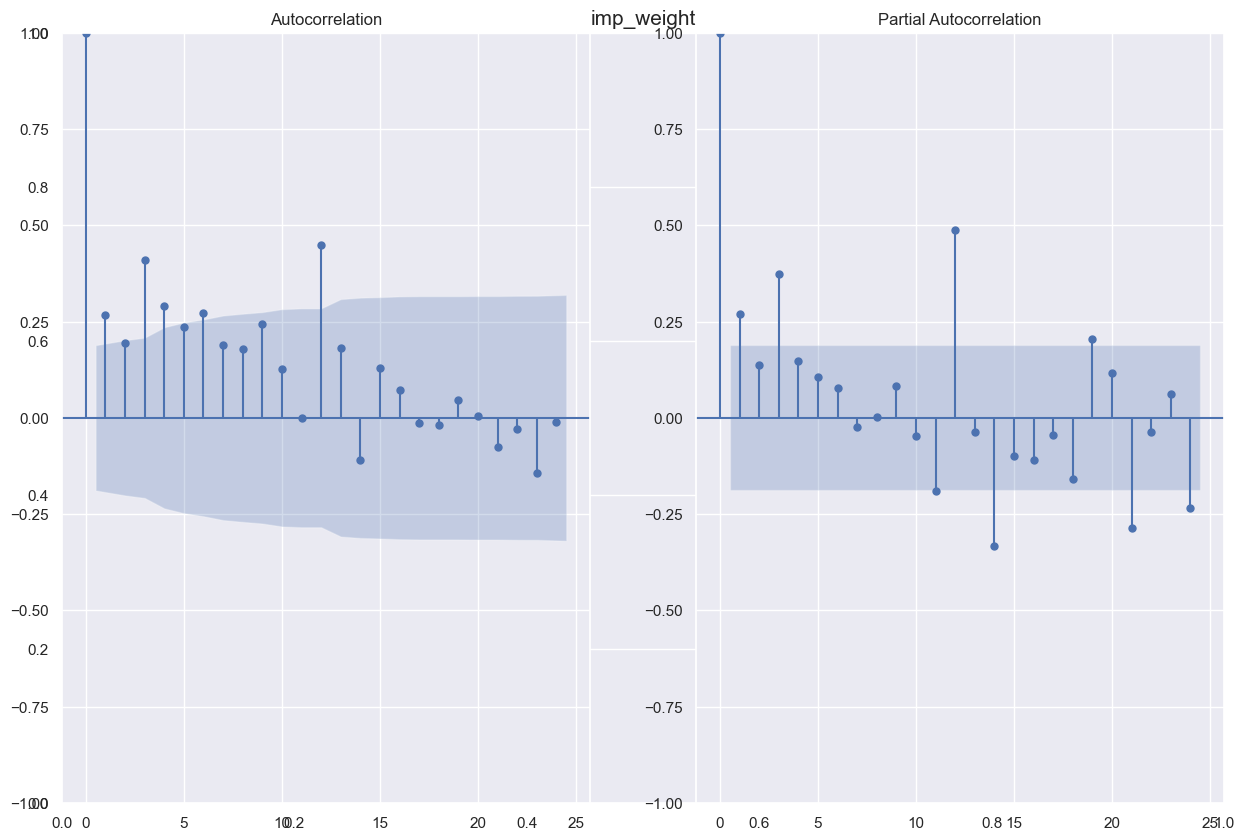

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.set(font_scale=1)
    for col in col_list:
        fig=plt.figure(figsize=(15,10))
        plt.title(col, fontsize=15)
        ax1=fig.add_subplot(121)
        fig = sm.graphics.tsa.plot_acf(df[col],lags=24,ax=ax1)
        ax2=fig.add_subplot(122)
        fig = sm.graphics.tsa.plot_pacf(df[col],lags=24,ax=ax2)

PACF shows a seasonality of 12. This is to be expected as commodity exports and imports often have yearly cycles!

The ACF and PACF plots also suggests AR processes.

# Modelling with SARIMA

In [12]:
# Reserve the last year as the testing set
train, test = pm.model_selection.train_test_split(df, test_size=12)

In [13]:
# Perform ADF and KPSS tests to find the differencing order
n_diffs = {}
for col_name in col_list:
    kpss_diffs = ndiffs(train[col_name], alpha=0.05, test='kpss', max_d=6)
    adf_diffs = ndiffs(train[col_name], alpha=0.05, test='adf', max_d=6)
    n_diffs[col_name] = max(adf_diffs, kpss_diffs)
n_diffs

{'exp_dol': 1, 'exp_weight': 1, 'imp_dol': 1, 'imp_weight': 1}

Now we have to decide on the SARIMA order parameters (e.g., the orders of the moving average component). Instead of manually guessing for the best order parameters, we will perform a search over them. The models with the lowest AIC will be chosen. 

To speed up the search, we will specify the seasonality lag to be 12 (expecting yearly effects). We will also set the integration order to be 1, as our ADF and KPSS tests indicated.

In [14]:
models = {}
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for col_name in col_list:
        print('Now doing analysis for: ' + col_name)
        model = pm.auto_arima(train[col_name], d=1, m=12, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=12,
                     max_order=None, trace=True)
        models[col_name] = model

Now doing analysis for: exp_dol
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=420.987, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=379.065, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=383.337, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=419.105, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=417.009, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=377.109, Time=0.13 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=378.973, Time=0.20 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=377.624, Time=0.05 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=383.800, Time=0.09 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=378.916, Time=0.19 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=378.822, Time=0.26 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=376.916, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=379.434, Time=0.03 sec
 ARIM

In [15]:
models['exp_dol'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   96
Model:             SARIMAX(0, 1, 1)x(2, 0, [], 12)   Log Likelihood                -183.613
Date:                             Sun, 19 Mar 2023   AIC                            375.226
Time:                                     19:33:37   BIC                            385.441
Sample:                                          0   HQIC                           379.353
                                              - 96                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3018      0.093     -3.249      0.001      -0.484      -0.120
ar.S.L12       0.8130      0.105      7.739      0.000       0.607       1.019
ar.S.L24      -0.2769      0.124     -2.229      0.026      -0.520      -0.033
sigma2         2.5621      0.364      7.032      0.000       1.848       3.276
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                17.49
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                            -0.47
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Our best models (lowest AIC) are:

- ) exp_dol: SARIMA(0,1,1)(2,0,0)[12]      

- ) exp_weight: SARIMA(0,1,0)(2,0,0)[12]   

- ) imp_dol: SARIMA(0,1,1)(0,0,1)[12]      

- ) imp_weight: SARIMA(0,1,1)(0,0,2)[12]      

Now we have to check whether the models have acceptable p-values:

In [16]:
print(models['exp_dol'].pvalues())
print(models['exp_weight'].pvalues())
print(models['imp_dol'].pvalues())
print(models['imp_weight'].pvalues())

ma.L1       1.156268e-03
ar.S.L12    9.994652e-15
ar.S.L24    2.584322e-02
sigma2      2.035788e-12
dtype: float64
ar.S.L12    1.147200e-03
ar.S.L24    8.340048e-04
sigma2      5.056013e-18
dtype: float64
ma.L1       0.000007
ma.S.L12    0.000548
sigma2      0.000032
dtype: float64
ma.L1       8.728495e-26
ma.S.L12    1.863056e-10
ma.S.L24    2.259214e-02
sigma2      1.842842e-15
dtype: float64


The p-values indicate that all of the model parameters are significant.

Let's plot how the model looks in comparison with the training data (in-sample predictions):

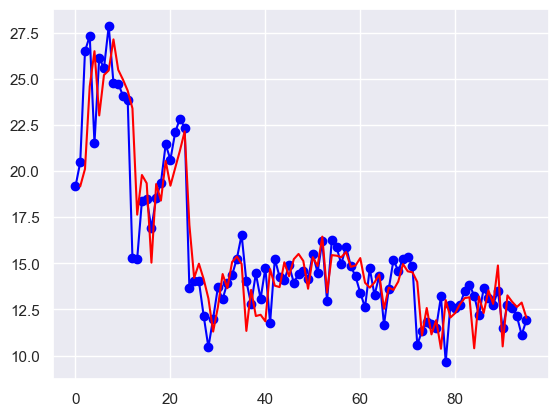

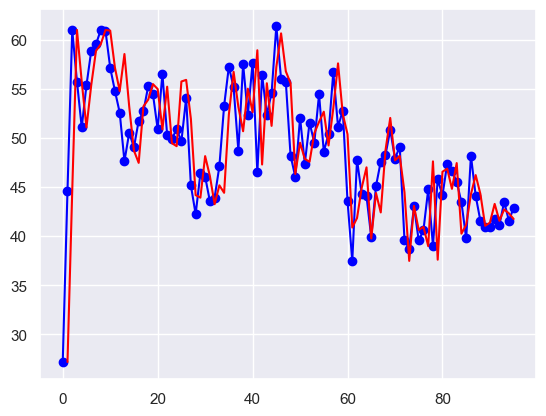

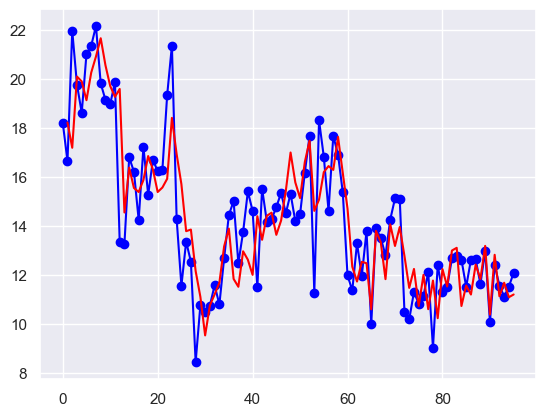

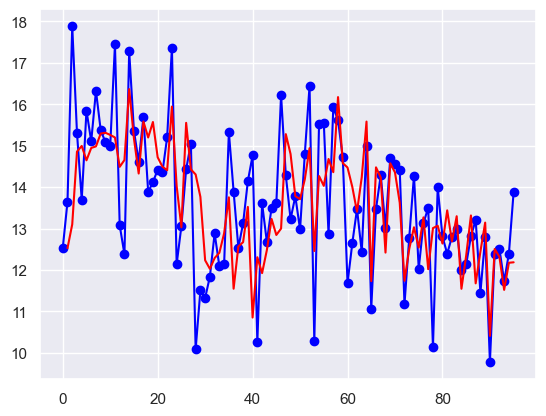

In [17]:
# In sample predictions
in_sample = {}
for col_name in col_list:
    x = np.arange(train.shape[0])
    plt.plot(x, train[col_name],color='blue',marker='o')
#    plt.scatter(x, train[col_name],marker='o')
    in_sample[col_name] = models[col_name].predict_in_sample(start=1).copy()
    plt.plot(in_sample[col_name],color='red')
    plt.show()

## Residual diagnostics

To validate the model, it is important to check for the statistics in the residuals. We will do this one by one, for each of of exp_dol, exp_weight, imp_dol, and imp_weight

exp_weight residual diagnostics:


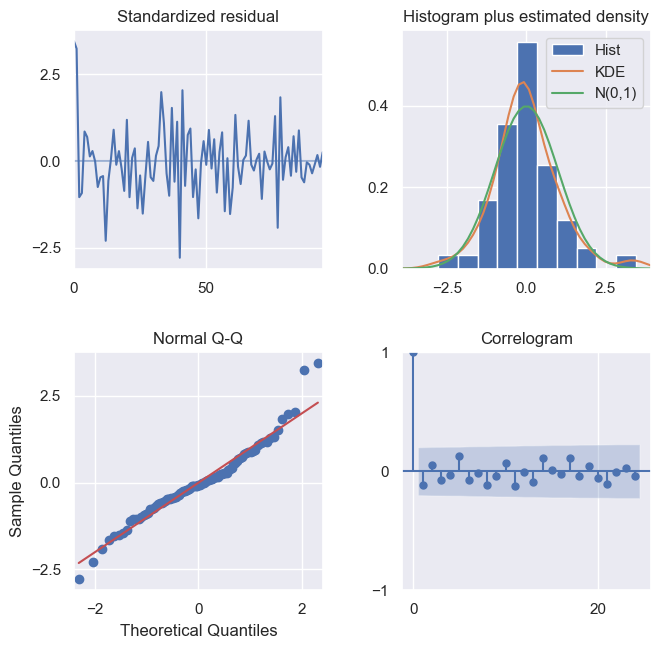

In [18]:
sns.set(font_scale=1)
print('exp_dol residual diagnostics:')
fig = models['exp_dol'].plot_diagnostics(lags=24,figsize=(7,7))
sns.set(font_scale=2)
fig.tight_layout()

exp_dol residual diagnostics:


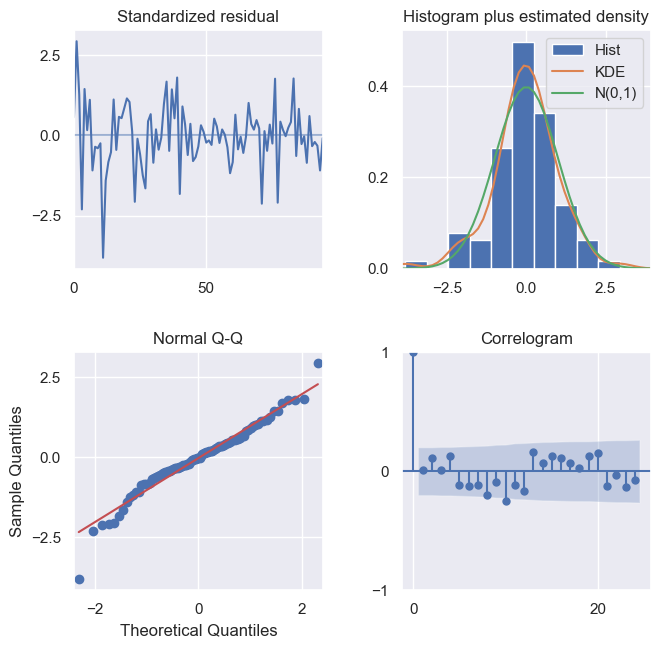

In [19]:
sns.set(font_scale=1)
print('exp_weight residual diagnostics:')
fig = models['exp_weight'].plot_diagnostics(lags=24, figsize=(7,7))
sns.set(font_scale=2)
fig.tight_layout()

imp_weight residual diagnostics:


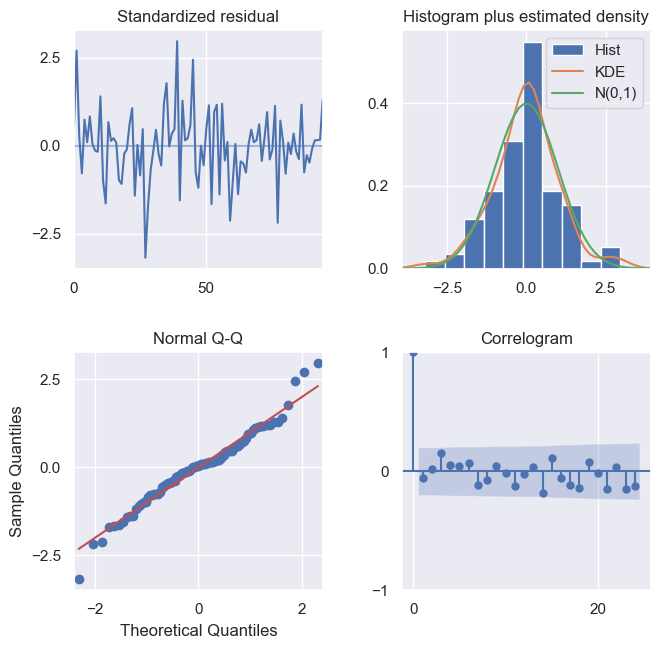

In [20]:
sns.set(font_scale=1)
print('imp_dol residual diagnostics:')
fig = models['imp_dol'].plot_diagnostics(lags=24,figsize=(7,7))
sns.set(font_scale=2)
fig.tight_layout()

imp_dol residual diagnostics:


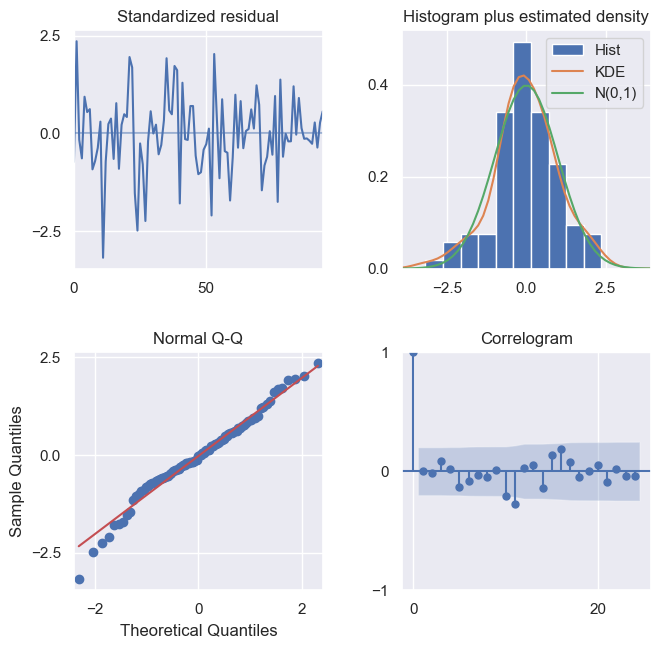

In [21]:
sns.set(font_scale=1)
print('imp_weight residual diagnostics:')
fig = models['imp_weight'].plot_diagnostics(lags=24,figsize=(7,7))
sns.set(font_scale=2)
fig.tight_layout()

As seen in the correlogram (ACF) plots, there are no more highly significant lags besides lag=0, meaning that our models are successful in picking out the SARIMA effects in the time series.

Looking at the QQ-plots and the histograms, there are some deviations from normality, especially near the mean. As the difference is slight, we will ignore this in this project (it will mostly affect the width of the confidence intervals of our forecasts). However, this can be a point to improve in the future.

Next we will perform a Ljung-Box (LB) test on the residuals. The null hypothesis for the LB test is no autocorrelation. If there is a significant p-value, that means there might be leftover SARIMA effects that are not modelled by our choice of SARIMA parameters. 

In [22]:
# Ljung-Box test on the residual to show that no SARIMA effects remain
for col in col_list:
    standarized_resid = models[col].resid()
    lb_st_res_sq = acorr_ljungbox(standarized_resid, lags = 12)
    print('Ljung-Box test for the residuals of: ' + col)
    print(lb_st_res_sq)

Ljung-Box test for the residuals of: exp_dol
      lb_stat  lb_pvalue
1    0.264110   0.607311
2    5.125668   0.077086
3    5.859552   0.118647
4    6.352769   0.174307
5    6.582491   0.253588
6    6.796918   0.340037
7    6.797465   0.450268
8    8.486324   0.387461
9    9.004510   0.436858
10  11.564986   0.315224
11  12.061607   0.359030
12  21.173390   0.047898
Ljung-Box test for the residuals of: exp_weight
     lb_stat  lb_pvalue
1   1.157862   0.281909
2   4.392331   0.111229
3   5.346948   0.148085
4   5.675029   0.224767
5   7.486785   0.186880
6   7.510246   0.276222
7   7.510537   0.377722
8   8.037413   0.429824
9   8.138617   0.520240
10  8.148320   0.614352
11  9.756339   0.552429
12  9.929300   0.622163
Ljung-Box test for the residuals of: imp_dol
     lb_stat  lb_pvalue
1   0.193995   0.659612
2   1.885243   0.389605
3   1.985991   0.575319
4   2.017605   0.732521
5   2.018724   0.846548
6   2.020938   0.917763
7   2.039413   0.957627
8   2.551038   0.959308
9   2.679

Of the 12 lags tested, there is only one very mildly significant lag: lag=12 for exp_dol. This means that our models have succesfully taken out most of the lag-correlations in the time series. 

# Forecasting import/export for the next year

We will now test the accuracy of our model by forecasting the test set. We will simulate being in the year of 2022: every month we will update our model with the actual datapoint for the month and forecast the time series for the next month. This generates our rolling forecasts. 

In [23]:
# Generate rolling forecasts
def forecast_one_step(model):
    one_step_forecast, confidence_int = model.predict(n_periods=1, return_conf_int=True, alpha=0.05)
    return (one_step_forecast.tolist()[0], np.asarray(confidence_int).tolist()[0])

results = {}
for col in col_list:
    forecast = []
    confidence_intervals = []

    for obs in test[col]:
        one_step_forecast, confidence_int = forecast_one_step(models[col])
        forecast.append(one_step_forecast)
        confidence_intervals.append(confidence_int)
        #Updates the existing model 
        models[col].update(obs)

    results[col] = {'forecast':forecast, 'conf':confidence_intervals, 
                    'mse':mean_squared_error(test[col], forecast), 'SMAPE':smape(test[col], forecast)}

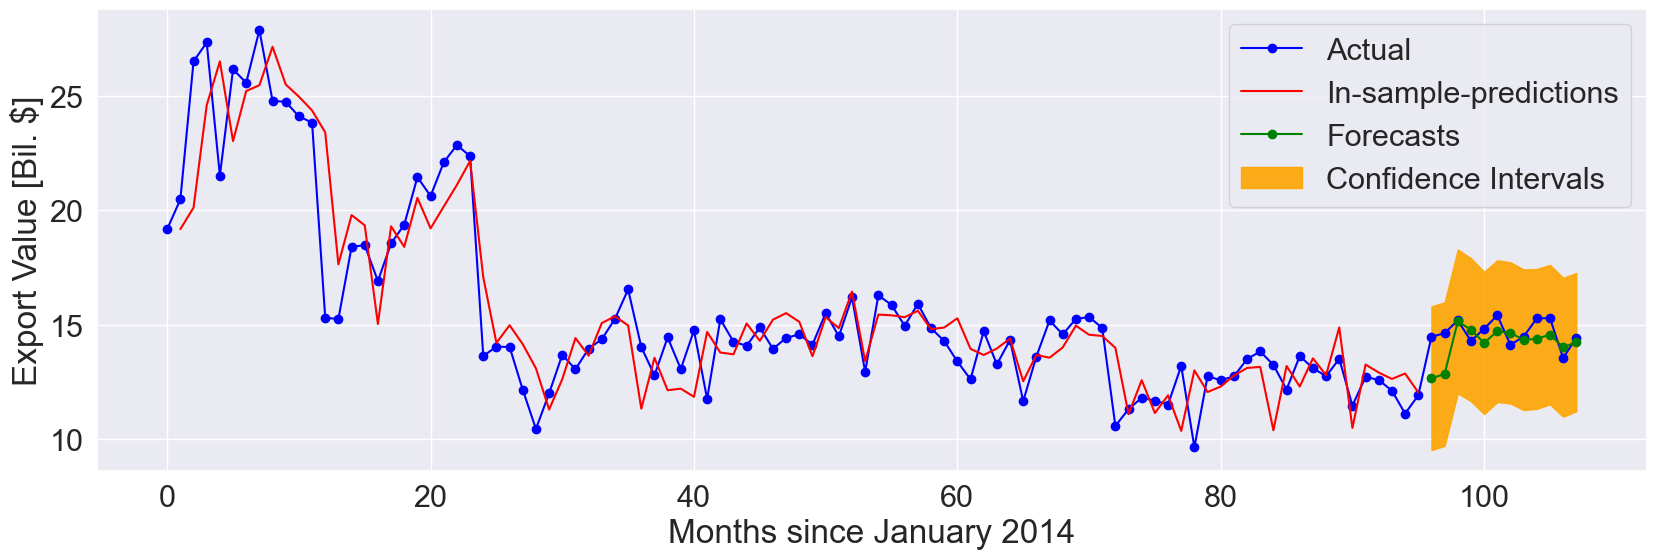

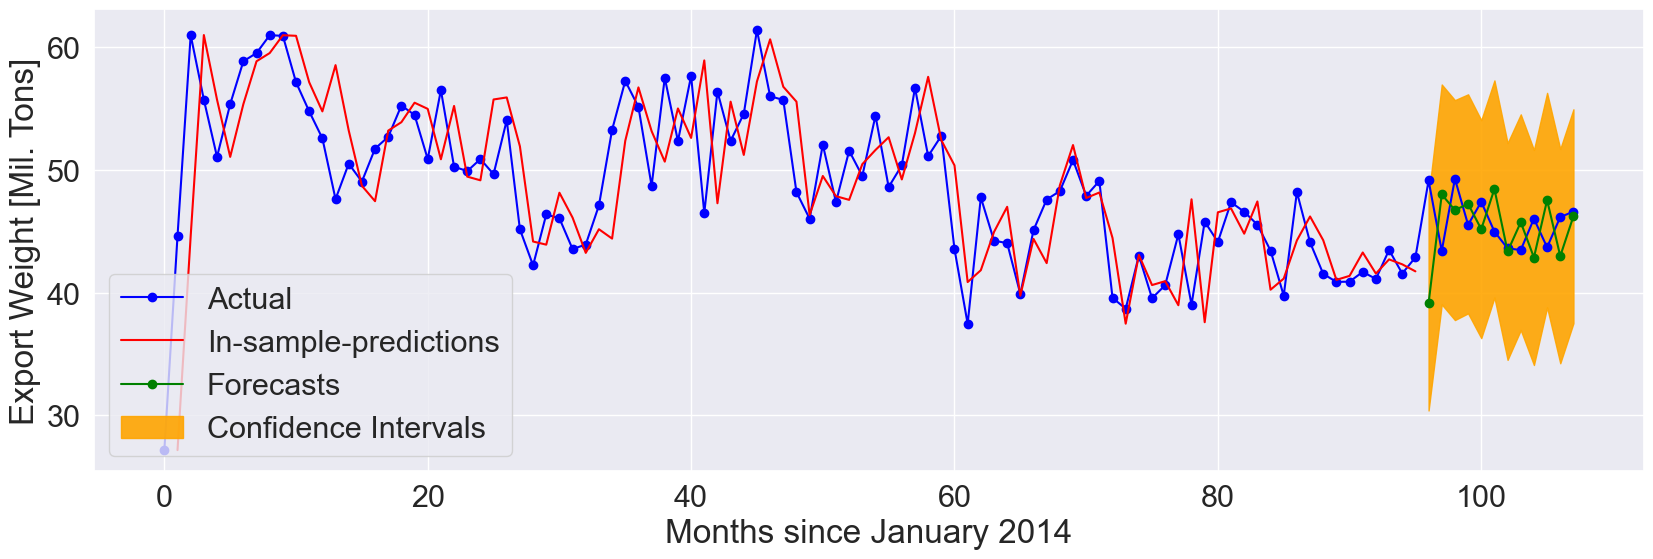

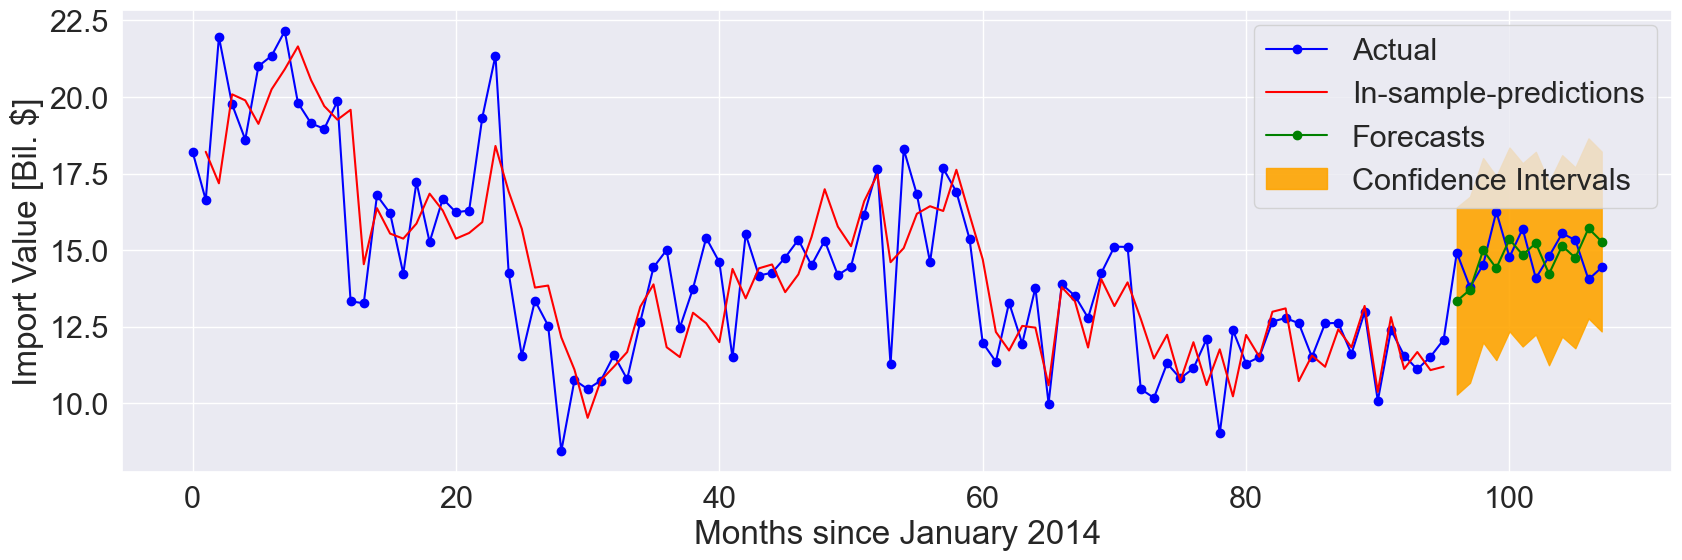

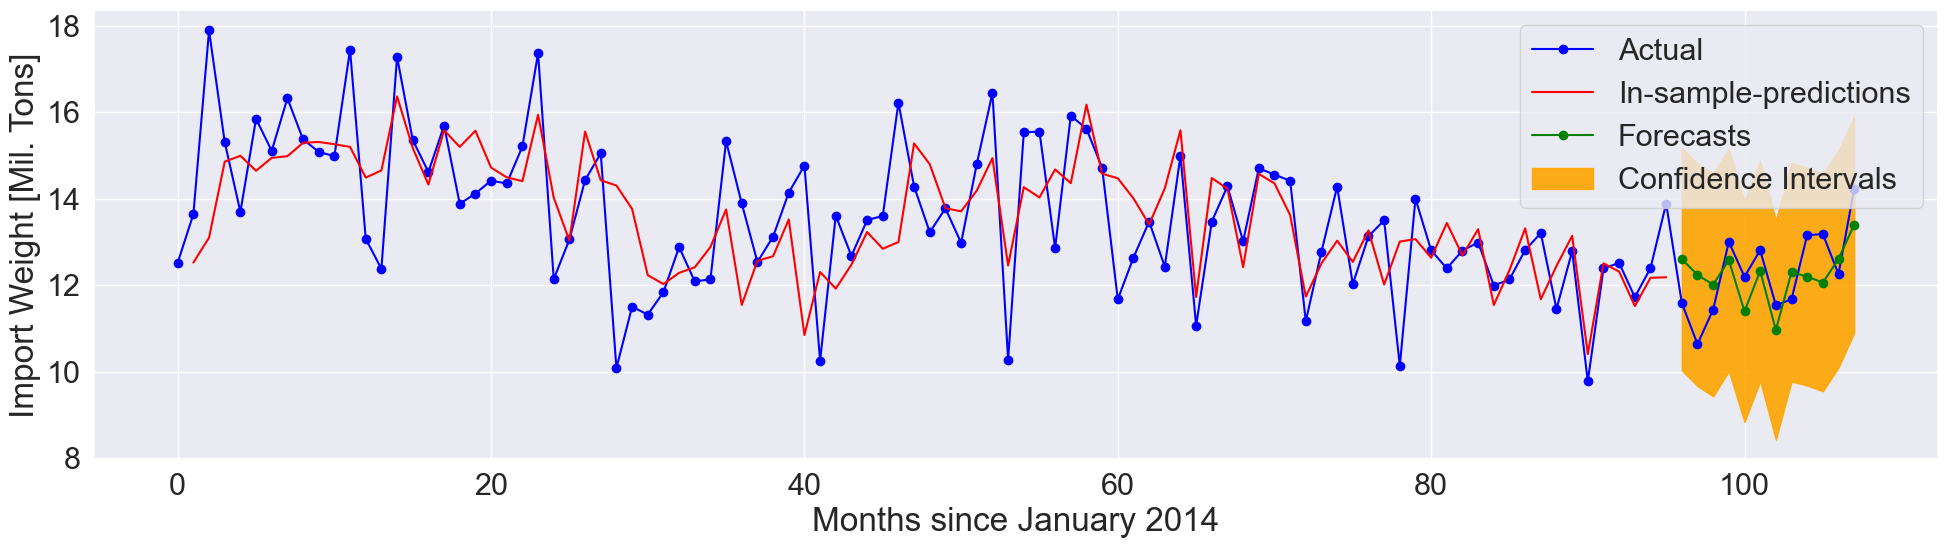

In [24]:
col_dict = {'exp_dol': 'Export Value [Bil. $]', 'exp_weight': 'Export Weight [Mil. Tons]', 
            'imp_dol':'Import Value [Bil. $]', 'imp_weight':'Import Weight [Mil. Tons]'}
sns.set(font_scale=2)
for col in col_list:
    fig, axes = plt.subplots(figsize=(20, 6))    
    axes.plot(df[col], color='blue', marker='o', label='Actual')

    axes.plot(in_sample[col],color='red', label='In-sample-predictions')
    axes.plot(test.index, results[col]['forecast'], color='green', marker='o',
                 label='Forecasts')
    
    axes.set_xlabel('Months since January 2014')
    axes.set_ylabel(col_dict[col])
    conf_int = np.asarray(results[col]['conf'])
    axes.fill_between(test.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")
    axes.legend()
    plt.savefig('forecast' + col, bbox_inches='tight')
fig.tight_layout()


In [25]:
for col in col_list:
    print('=======' + col + '=======')
    print('rmse:', np.sqrt(results[col]['mse']))
    print('SMAPE:', results[col]['SMAPE'])

=======exp_dol=======
rmse: 0.8866693533504487
SMAPE: 4.921547194743248
=======exp_weight=======
rmse: 3.957657304297851
SMAPE: 6.92908544349057
=======imp_dol=======
rmse: 1.033813981243585
SMAPE: 5.968486665235122
=======imp_weight=======
rmse: 0.849934653492502
SMAPE: 6.391855182802208


The SMAPE values indicate a good fit, i.e., that we captured the general trend of the time series. However, the confidence intervals of our forecasts are wide -- certainly too wide if you want to use our results to build a trading strategy or inform a political decision! This reflects the fact that the pattern in the data are difficult to discern! One way to improve our prediction is to obtain higher resolution data, which is not easy to do, or to extend our data to include years prior to 2014. We will leave the latter for future work.

# Cointegration analysis

First, because the time series are I(1) processes, we have to perform differencing before performing our cointegration tests

In [26]:
diffs = {}
for col_name in col_list:
    diffs[col_name] = df[col_name].diff().iloc[1:]
diffs = pd.DataFrame(diffs)

In [27]:
diffs

,exp_dol,exp_weight,imp_dol,imp_weight
1,1.299195,17.453835,-1.572592,1.118366
2,6.024583,16.378692,5.323906,4.247102
3,0.824807,-5.264504,-2.204968,-2.578859
4,-5.812459,-4.665743,-1.148162,-1.616101
5,4.640289,4.300458,2.394566,2.153325
...,...,...,...,...
103,0.357513,-0.139591,0.711527,0.134810
104,0.794204,2.558323,0.752859,1.482640
105,0.016913,-2.338141,-0.218102,0.025517
106,-1.748030,2.477075,-1.286386,-0.926065


Cointegration test with the augmented Engle-Granger two-step cointegration test. The null hypothesis is no cointegration. If the p-value is small, we can reject the hypothesis that there is no cointegrating relationship.

In [28]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    coint_table = [[0 for j in col_list] for i in col_list]
    for i, col1 in enumerate(col_list):
        for j, col2 in enumerate(col_list):
            coint_table[i][j] = coint(diffs[col1],diffs[col2])[1]

In [29]:
print('The cointegration p-value between export value and export weight is', coint_table[0][1])
print('The cointegration p-value between export value and import value is', coint_table[0][2])
print('The cointegration p-value between export value and import weight is', coint_table[0][3])

The cointegration p-value between export value and export weight is 0.0020508161084110323
The cointegration p-value between export value and import value is 0.055975091858328226
The cointegration p-value between export value and import weight is 0.07550144972823052


Export value and export weight is obviously cointegrated. However, cointegration between export value and either import value and import weight is not detected with significant p-value. If it is true that a healthy economy should strive for cointegration between exports and imports, this result argues that it might be necessary for Indonesia to tweak its export/import policies!

# Conclusion

## Time series modelling with SARIMA

We modelled Indonesia's export and import time series (both in dollar values and weights) from Jan 2014 to Dec 2022 with SARIMA. The best (lowest AIC) SARIMA orders are found to be: 

- ) exp_dol: SARIMA(0,1,1)(2,0,0)[12]

- ) exp_weight: SARIMA(0,1,0)(2,0,0)[12]

- ) imp_dol: SARIMA(0,1,1)(0,0,1)[12]

- ) imp_weight: SARIMA(0,1,1)(0,0,2)[12]

Predictions from these models are tested against the last year in the dataset obtaining SMAPE values of:

- ) Export values: 4.92

- ) Export weights: 6.93

- ) Import values: 5.97

- ) Import weights: 6.39

While the SMAPE values indicate that we managed to model the general trend of the time series well, the confidence intervals of the forecasted values are large. As such, caution should be employed before using predictions from these models to make important trading or policy decisions.

## Cointegration analysis

Using the augmented Engle-Granger test, we found that the cointegration p-value between export value and import value is 0.056 while the p-value between export value and import weight is 0.076. Neither of these are small enough to claim significant detection of cointegration. If it is true that a healthy economy should strive for cointegration between exports and imports, this result argues that it might be necessary for Indonesia to look into its export/import policies! 

## Possible improvements and future directions

We identified a few weaknesses in our analysis that could be improved in the future:

1) Looking at the residual QQ-plots and histograms, we found deviations from normality. This will affect the widths of the confidence intervals of our forecasts. Future work can perform modelling with other distributions (e.g., Student's t or skewed-t distributions).

2) Extending the time series included in the analysis from 2014 down to 1998 would give more baseline for the model to learn the pattern in the time series (especially the cointegration pattern). Care should be taken when using datapoints near 1998, as post-New Order policies might have not taken effect yet. 

Here are some future research directions that could be interesting to explore:

1) Performing similar analysis to particular sectors of imports/exports, e.g., just agricultural products, or even single items like coffee or cocoa.
2) Exploring relationships between Indonesia's imports/exports and various environmental time series (e.g., temperature or rainfall time series) with vector auto-regression.
3) Analyzing differences in the imports/exports time series between the post-New Order era and the New Order era.